# Draw from a set of Moffat profiles to make oversampled PSFs roughly appropriate to HSC

This is a stopgap...in working with the real HSC data, we'll grab the PSF appropriate for each image from the archive and use that. 



In [16]:
import warnings
import numpy as np

from astropy.modeling.functional_models import Moffat2D
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table
from scipy import stats

In [17]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]

There is info on the FWHM distribution for Subaru at https://www.naoj.org/Observing/Telescope/ImageQuality/Seeing/. We'll use this to guide a probability distribution for the FWHM distribution. I'm not finding any info on the distribution of the Moffat parameters, so leave it at varying gamma for now. The distribution is binned at 0.1" intervals.

In [19]:
t = Table.read('data/subaru_seeing.txt',format='ascii.commented_header')
t['freq'].sum()
t[:5]

fwhm,freq
float64,float64
0.047,0.0006027
0.149,0.0008349
0.249,0.011
0.346,0.113
0.448,0.224


Create a picker for the PSF. The `fwhm` routine is just for validating that the distribution 
looks okay in comparison to the Subaru data. The `get_oversampled_psf` routine returns the oversampled PSF. 
The native Subaru pixel scale is 0.17"/pixels and these are oversampled by default by a factor of 4.
We're feeding it a FITS file with this oversampling as a template so we can get a WCS on it, for what it's worth. We won't bother writing out the file, but just return the Moffat parameters gamma (in arcsec) and alpha so we can put them in a table.

In [ ]:
class HSCMoffatPSFPicker:
    def __init__(self,template_psf_file='generated_data/moffat_oversampled_psf.fits',
                 oversampling=4,gamma0=2.3,alpha0=1.9,sigma_log_gamma=0.15):
        hdu = fits.open(template_psf_file)
        template_psf = hdu[0].data
        self.x0,self.y0 = self.find_center(template_psf)
        self.x,self.y = np.mgrid[:template_psf.shape[0], :template_psf.shape[1]]
        self.oversampling = oversampling
        self.c1 = 0.30
        self.sigma = sigma_log_gamma
        self.gamma0 = gamma0*oversampling
        self.alpha = alpha0
        self.gscatter = stats.gumbel_r(loc=np.log10(self.gamma0),scale=self.sigma) # Skewed distribution
    def find_center(self,array):
        return (np.array(array.shape)-1)/2
    def gamma(self,size=1):
        return 10.**self.gscatter.rvs(size=size)
    def fwhm(self,size=1):
        gammas = self.gamma(size=size)
        fwhm = []
        for g in gammas:
            m2d = models.Moffat2D(x_0=self.x0,y_0=self.y0,gamma=g,alpha=self.alpha)
            fwhm += [m2d.fwhm/self.oversampling]
        return np.array(fwhm)
    def get_oversampled_psf(self):
        gamma = self.gamma(size=1)[0]
        alpha = self.alpha
        print(self.x0,self.y0,gamma,alpha)
        m2d = models.Moffat2D(x_0=self.x0,y_0=self.y0,gamma=gamma,alpha=alpha)
        psf = m2d(self.x,self.y) 
        return gamma,alpha,psf

In [20]:
# Test the script version
from psf_picker import HSCMoffatPSFPicker

In [26]:
pf = HSCMoffatPSFPicker(max_gamma_factor=400.)

Get a bunch of random FWHMs and convert to arcseconds

In [27]:
fwhms = pf.fwhm(size=10000)*0.17 # HSC pixel scale is 0.17
np.percentile(fwhms,1.),np.percentile(fwhms,99.)

(0.30687486628084965, 2.644269242871741)

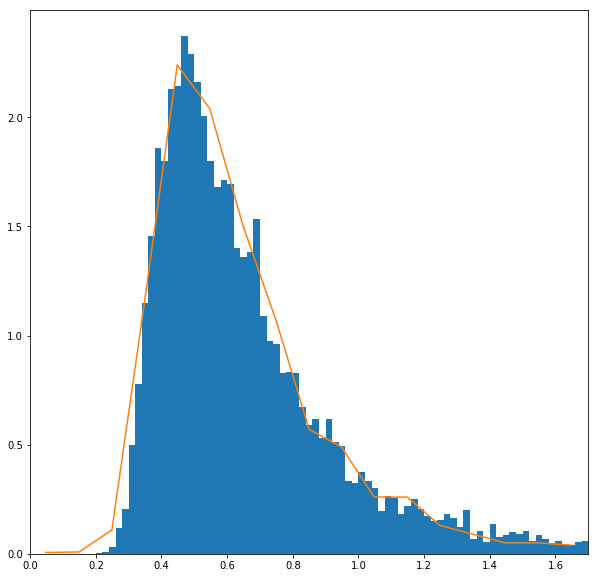

In [28]:
n,bins,patches = plt.hist(fwhms,np.arange(0.,2.5,0.02),density=True)
plt.xlim(0,1.7)
plt.plot(t['fwhm'],t['freq']/0.1)

Set a maximum gamma (relative to the "mean") because the HSC survey probably observes only in good conditions. Need to find out what the distribution really is, or better still just go grab real PSFs.

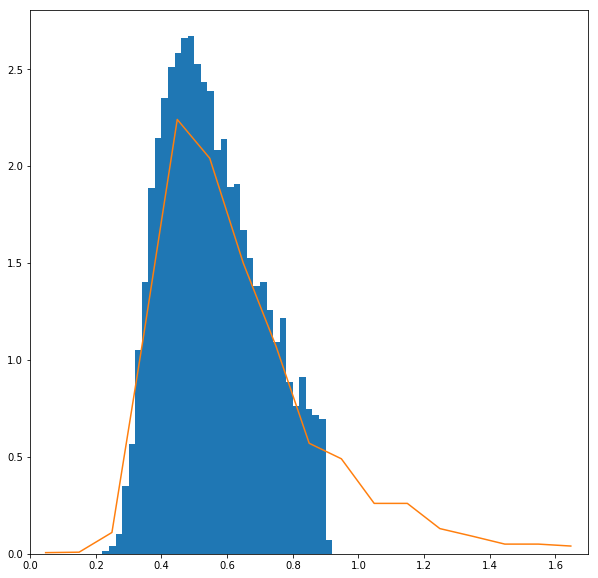

In [29]:
pf = HSCMoffatPSFPicker(max_gamma_factor=4.)
#gammas = pf.gamma(size=10000)/4.
fwhms = pf.fwhm(size=10000)*0.17 # HSC pixel scale is 0.17
np.percentile(fwhms,1.),np.percentile(fwhms,99.)
n,bins,patches = plt.hist(fwhms,np.arange(0.,2.5,0.02),density=True)
plt.xlim(0,1.7)
plt.plot(t['fwhm'],t['freq']/0.1)

In [ ]:
g,a,psf = pf.get_oversampled_psf()
plt.imshow(psf)